# Vars

In [ ]:
LLM_name = "qwen2.5vl:3b"

: 

# Load LLM

In [2]:
from langchain_ollama import OllamaLLM

llm = OllamaLLM(model=LLM_name)  


# Load embedding model

In [3]:
from langchain_huggingface import HuggingFaceEmbeddings

model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}
hf = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

#test
embed = await hf.aembed_query("hello")
print("done")

C:\Users\WELTINFO\Desktop\models\RAG qwen\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


done


# Vector store

In [4]:
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS

embedding_dim = len(embed)
index = faiss.IndexFlatL2(embedding_dim)

vector_store = FAISS(
    embedding_function=hf,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

print(vector_store)

# Load and chunk the data

In [5]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter


#lead folder with DirectoryLoader
loader = DirectoryLoader("./data/", glob="**/*.txt", show_progress=True)
docs = loader.load()
print("data loaded successfully")


#split the docs to chunks with textspliter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=800,  # chunk size (mb chars)
    chunk_overlap=200,  # chunk overlap (nb chars)
    add_start_index=True,  # track index in original document (idk wchm3ntha)
)
all_splits = text_splitter.split_documents(docs)
print(f"Split blog post into {len(all_splits)} sub-documents.")

#sotre the splits in vector sotre
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:2])

 25%|█████████████████████                                                               | 1/4 [00:04<00:12,  4.25s/it]libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.
libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.
libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.
100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.08s/it]


data loaded successfully
Split blog post into 4 sub-documents.
['b7923881-9cf0-4644-8c34-931354f5799e', '6a191708-8b5d-4a10-801a-0c06d97b2855']


# Retrieval and Generation

**1 Create prompt**

In [6]:
from langchain_core.prompts import ChatPromptTemplate

#create custom prompt
prompt = ChatPromptTemplate.from_template(
    "Vous êtes un assistant chargé de répondre à des questions. Utilisez les éléments de contexte suivants pour répondre à la question. Si vous ne connaissez pas la réponse, dites simplement que vous ne savez pas. Utilisez au maximum trois phrases et restez concis..\n\n"
    "Contexte : {context}\n\n"
    "Question : {question}\n\n"
    "Réponse :"
)


**2 Create the graph**

In [7]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response}

In [8]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

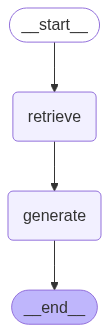

In [9]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

# Test (ncahlh tmchi)

In [11]:
result = graph.invoke({"question": "Qui est anis"})

print(f'Answer: {result["answer"]}')

Answer: Anis est un CHIKOUR.
